In [3]:
using Pkg
Pkg.activate("/home/fedflorio/master_thesis/")

  Activating project at `~/master_thesis`


In [4]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, PyPlot
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
include("/home/fedflorio/master_thesis/Utilities/roc.jl");

In [5]:
T = 100
N = 10
seed = 4

c = 2
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)

λ_unif = 0.4
ρ_unif = 0.4
λ = zeros(N,N)
for i in CartesianIndices(λ)
    if !iszero(g.A[i])
        # λ[i] = rand()
        λ[i] = λ_unif
    end
end
λ = sparse(λ)
# ρ = rand(N)
ρ = fill(ρ_unif,N)
γ = 0.5;

# T = 7
# N = 2
# seed = 6

# A = [0 1; 1 0]
# g = IndexedGraph(A)

# λ_unif = 0.7
# ρ_unif = 0.6
# λ = sparse(λ_unif .* A)
# # λ = sparse([0 1e-12; λ_unif 0])
# ρ = fill(ρ_unif, N)
# γ = 0.5;
;

In [6]:
sis = SIS_heterogeneous(λ, ρ, T; γ);
bp_obs = mpbp(sis);

In [7]:
g.A

10×10 SparseMatrixCSC{Int64, Int64} with 30 stored entries:
  ⋅  ⋅   1  2  4   5   ⋅   ⋅   ⋅  14
  ⋅  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   9   ⋅
  1  ⋅   ⋅  3  ⋅   ⋅   6   ⋅  10   ⋅
  2  ⋅   3  ⋅  ⋅   ⋅   7   ⋅   ⋅   ⋅
  4  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  5  ⋅   ⋅  ⋅  ⋅   ⋅   8   ⋅  11   ⋅
  ⋅  ⋅   6  7  ⋅   8   ⋅   ⋅  12   ⋅
  ⋅  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅  13   ⋅
  ⋅  9  10  ⋅  ⋅  11  12  13   ⋅  15
 14  ⋅   ⋅  ⋅  ⋅   ⋅   ⋅   ⋅  15   ⋅

In [8]:
obs_times = collect(0:T)
nobs = floor(Int, N * length(obs_times) * 1.0)
obs_fraction = nobs / N
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp_obs, nobs, times = obs_times .+ 1, softinf=Inf; rng);

In [9]:
X

10×101 Matrix{Int64}:
 2  1  2  1  2  2  2  1  2  2  2  1  1  …  2  1  2  2  2  1  2  2  1  2  2  1
 2  2  2  1  2  2  1  2  2  2  1  1  1     1  2  2  1  1  2  2  1  1  1  1  1
 2  2  2  1  2  2  2  2  2  2  2  2  1     1  1  2  2  1  2  1  1  2  2  2  2
 2  2  1  2  2  2  2  2  1  2  1  2  2     2  2  2  2  2  2  1  2  2  2  1  2
 2  2  1  2  2  2  2  2  2  2  1  2  1     1  2  1  1  2  1  1  1  1  1  1  1
 2  2  2  2  2  2  1  2  1  2  2  2  2  …  1  2  1  1  2  2  2  1  1  1  1  1
 1  2  2  2  2  2  2  1  2  2  2  2  2     2  1  2  1  1  2  2  2  2  2  1  2
 2  1  1  2  2  2  1  1  1  1  1  1  1     1  2  1  1  1  1  2  1  1  1  1  1
 1  2  2  2  2  1  2  2  1  2  1  2  2     2  2  1  1  2  2  2  1  1  1  2  2
 2  2  2  1  2  1  2  1  2  1  2  2  1     2  1  1  1  1  2  2  2  1  1  1  2

In [10]:
λinit = 0.1
ρinit = 0.1

A_complete = ones(N,N) - I
g_complete = IndexedGraph(A_complete)
λ_complete = sparse(λinit.*A_complete)
ρ_complete = fill(ρinit, N)

sis_inf = SIS_heterogeneous(g_complete, λ_complete, ρ_complete, T; γ, ϕ=deepcopy(bp_obs.ϕ))
bp_inf = mpbp(sis_inf);

In [11]:
svd_trunc = TruncBond(3)

iters, cb = inference_parameters!(bp_inf, method=3, maxiter=30, λstep=0.01, ρstep=0.01, logpriorder=(x)->0.0);
# iters, = iterate!(bp_inf, maxiter=100; svd_trunc, tol=1e-6, damp=0.0);

Running Gradient Ascent: iter 30    Time: 0:16:39
  Δ:              0.999999


In [12]:
xplot, yplot, auc = roc(cb.data[end].λ, λ)
auc

0.845

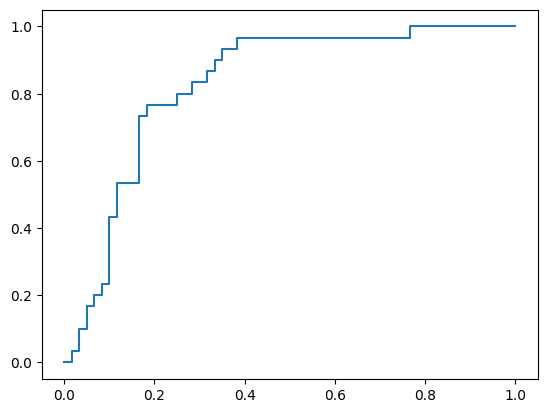

In [14]:
close("all")
plot(xplot,yplot);